In [1]:
%matplotlib inline

In [2]:
import os
path = os.path.abspath(os.getcwd())

In [3]:
import math
import numpy as np
import pandas as pd
import pylab as py

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from fitter import Fitter

from scipy import fft
from scipy.optimize import curve_fit, minimize
from scipy.stats import kstest, norm, laplace, entropy, cauchy, entropy
from sklearn.feature_selection import mutual_info_regression

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [4]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.style.use('ggplot')

In [5]:
pd.set_option("display.max_colwidth",100)

In [6]:
data_files = [
    'moduntu_HP_desktop_trace_jiffies_23.10.15_1h'
]

# I - Data formatting
## 1) Text to CSV

## 2) Data import

In [7]:
filename = data_files[0]
data_path = path + "\\csv\\" + filename + ".csv"
data = pd.read_csv(data_path).drop(['count', 'swab'], axis=1)
data.head(5)

,timestamp,regs,irq,jiffies,idle
0,51036824464,18446744072313314992,0,4294892297,True
1,51045994495,18446744072313314992,0,4294892298,True
2,51055176440,18446744072313314992,0,4294892299,True
3,51064359489,18446744072313314992,0,4294892300,True
4,51073541871,18446744072313314992,0,4294892301,True


In [8]:
data[data["idle"]==True]

,timestamp,regs,irq,jiffies,idle
0,51036824464,18446744072313314992,0,4294892297,True
1,51045994495,18446744072313314992,0,4294892298,True
2,51055176440,18446744072313314992,0,4294892299,True
3,51064359489,18446744072313314992,0,4294892300,True
4,51073541871,18446744072313314992,0,4294892301,True
...,...,...,...,...,...
399675,8560395086836,18446744072293158894,90,4295818970,True
399676,8560432770404,18446744072293158894,90,4295818974,True
399677,8560433316562,18446744072293158894,90,4295818974,True
399678,8560471000613,18446744072293158894,90,4295818978,True


In [9]:
data.dtypes

timestamp     int64
regs         uint64
irq           int64
jiffies       int64
idle           bool
dtype: object

In [10]:
def get_stats(data, col):
    print("Stats for " + col + " :")
    stats = data[col].value_counts()
    stats_perc = data[col].value_counts(normalize = True)
    
    total = 0
    for i in range(len(stats)):
        total = stats[i]
    
    for i in range(len(stats)):
        print(str(stats.index[i]) + "\t\t", str(stats[stats.index[i]]) + 
              '\t\t', str(round(stats_perc[stats.index[i]] * 100)) + '%')
        
    print()

In [11]:
for filename in data_files:
    print(filename)

moduntu_HP_desktop_trace_jiffies_23.10.15_1h


In [12]:
idle_true, count = 0,0
for filename in data_files:
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    count += data.shape[0] 
    stats = data["idle"].value_counts()
    idle_true += stats[True]
    
    print(filename)
    for col in ["idle"]:
        get_stats(data, col)

print(count, idle_true, idle_true/count)

moduntu_HP_desktop_trace_jiffies_23.10.15_1h
Stats for idle :
True		 364229		 91%
False		 35451		 9%

399680 364229 0.9113015412329863


# II - Direct analysis
## 1) Density visualization

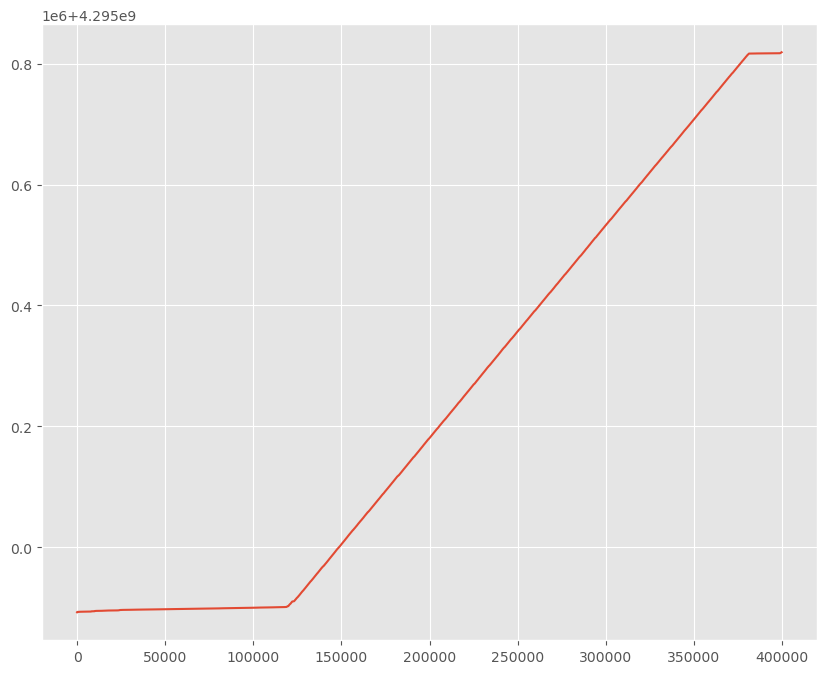

In [13]:
for file in data_files:
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    fig, ax = plt.subplots()
    ax.plot(data.jiffies)

In [14]:
def tup_string(selection):
    tup_str = ""
    for tup in selection:
        if not tup_str == "":
            tup_str += ", "
        tup_str += str(tup[0]) + " = " + str(tup[1])
    return tup_str

In [15]:
def data_hist(filename, column, selection = [], crop = (None, None), slicer = (None, None), log = False, bins = None):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    # Selection: select data according to other columns (origin, process...)
    for tup in selection: 
        data = data[data[tup[0]] == tup[1]] 

    # Cropping: remove crop[0] % of beginning or crop[0] of end of the data (if not idle)
    n = data.shape[0]
    if crop[0] != None and int(crop[0]*n) > 0: 
        data = data.tail(-int( n*crop[0] ))
    if crop[1] != None and int(crop[1]*n) > 0: 
        data = data.head(-int( n*crop[1] ))
    
    fig, ax = plt.subplots()
    bins = max(int(data.shape[0]/128) if not bins else bins, 1)
    plt.hist(data[column], density=True,  log = log, bins = bins)
    print("Histogram of", filename, ":")
    print("\t selection:", tup_string(selection))
    print("\t crop values:", str(0 if not crop[0] else int(crop[0]*n))+",", str(0 if not crop[1] else int(crop[1]*n)))
    print("\t # of elements:", str(data.shape[0]))
    print("\t # of bins:", str(bins))
    print("\t log =", str(log))
    
    ax.set_xlabel(u'Jiffies value')
    ax.set_ylabel('Frequency')

    plt.show()

Histogram of moduntu_HP_desktop_trace_jiffies_23.10.15_1h :
	 selection: 
	 crop values: 0, 0
	 # of elements: 399680
	 # of bins: 3122
	 log = True


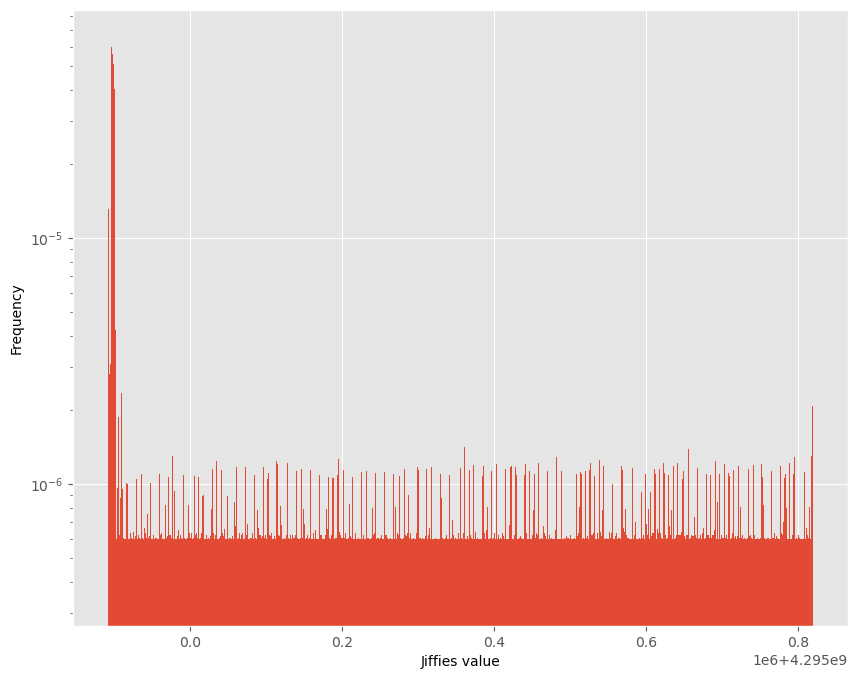

In [16]:
for file in data_files:
    data_hist(file, 'jiffies', selection = [], crop = (0, 0), slicer = (None, None), 
              log = True)

Histogram of moduntu_HP_desktop_trace_jiffies_23.10.15_1h :
	 selection: idle = True
	 crop values: 72845, 36422
	 # of elements: 254962
	 # of bins: 500
	 log = False


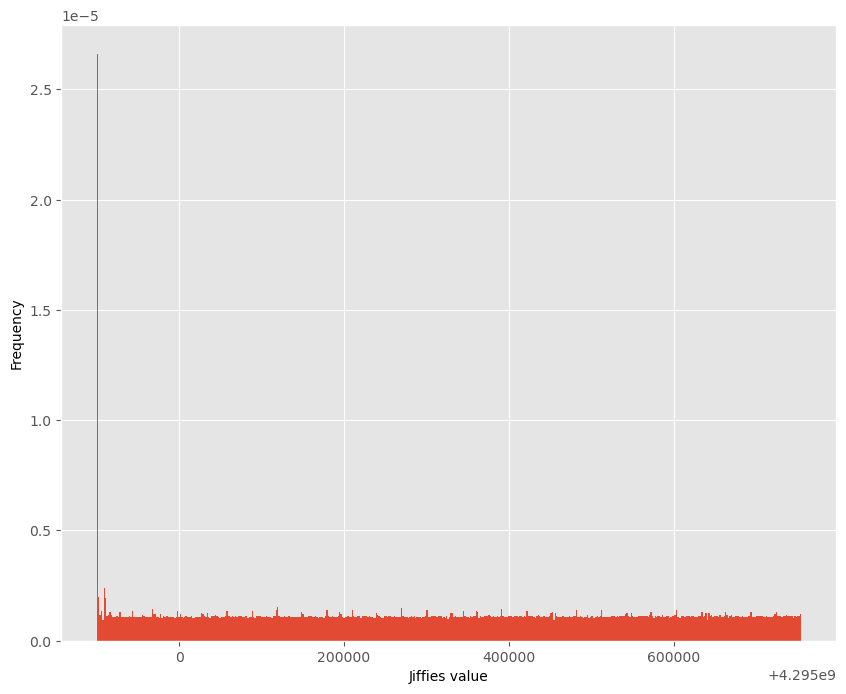

In [17]:
for file in data_files:
    data_hist(file, 'jiffies', selection = [('idle', True)], crop = (0.2, 0.1), slicer = (None, None), 
              log = False, bins = 500)

## 2) Independence of inputs
### A/ Autocorrelation coefficient

In [18]:
def fft_autocorr(x):
    x = np.asarray(x)
    N = len(x)
#     x = x-x.mean()
    s = fft.fft(x, N*2-1)
    result = np.real(fft.ifft(s * np.conjugate(s), N*2-1))
    result = result[:N]
    result /= result[0]
    return np.array(result.astype(float))

def maple_autocorr(x): 
    x = np.asarray(x)
    y = x-x.mean()
#     y = x / max(x)
    
    autocorr = np.correlate(y, y, mode='full').astype(float)
#     autocorr = np.correlate(y, y, mode='same').astype(float)
    autocorr = autocorr[len(autocorr)//2:]
    autocorr /= autocorr[0]
    return np.array(autocorr.astype(float))

autocorr len: 1000


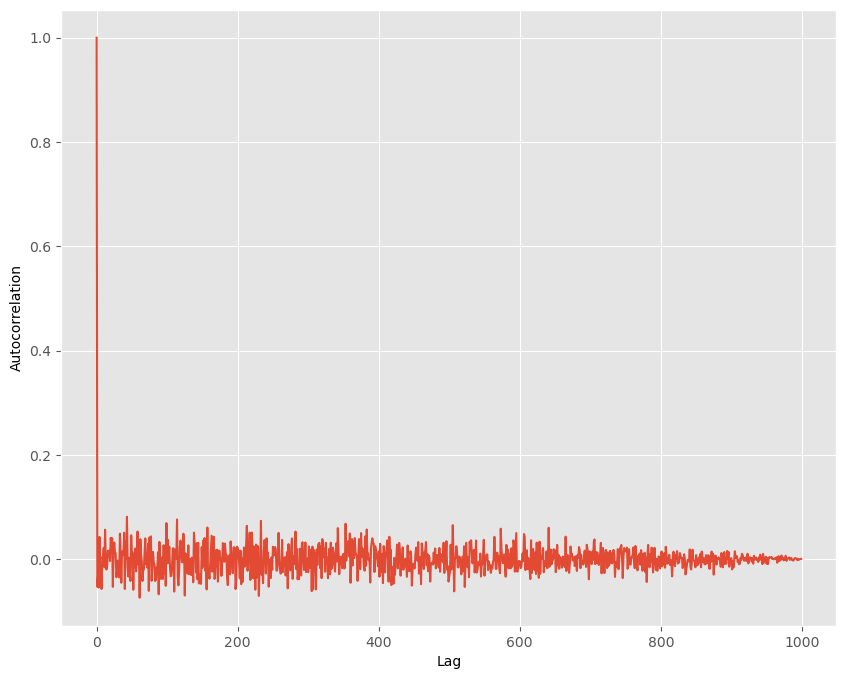

In [19]:
def plot_autocorr(x, i, method):
    if method=='maple':
        autocorr = maple_autocorr(x)
    else:
        autocorr = fft_autocorr(x)

    if i!=None:
        autocorr = autocorr[:i]
    print("autocorr len:", len(autocorr))
#     print("Autocorrelation:", autocorr)
    
    plt.plot(autocorr)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.show()
    
x = np.random.randn(1000)
plot_autocorr(x, None, 'maple')

In [20]:
def data_autocorr(filename, column, crop, max_lag, method):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    x = np.array(data[column])
    
    n = len(x)
    i,j = 0 if crop[0]==None else int(crop[0]*n), n if crop[1]==None else int(crop[1]*n)
    if i<j: 
        x = x[i:j]

    print("array len:", len(x))
    print("head values:", x[:10])
        
    plot_autocorr(x, max_lag, method)

array len: 399680
head values: [4294892297 4294892298 4294892299 4294892300 4294892301 4294892302
 4294892303 4294892304 4294892305 4294892306]
autocorr len: 399680


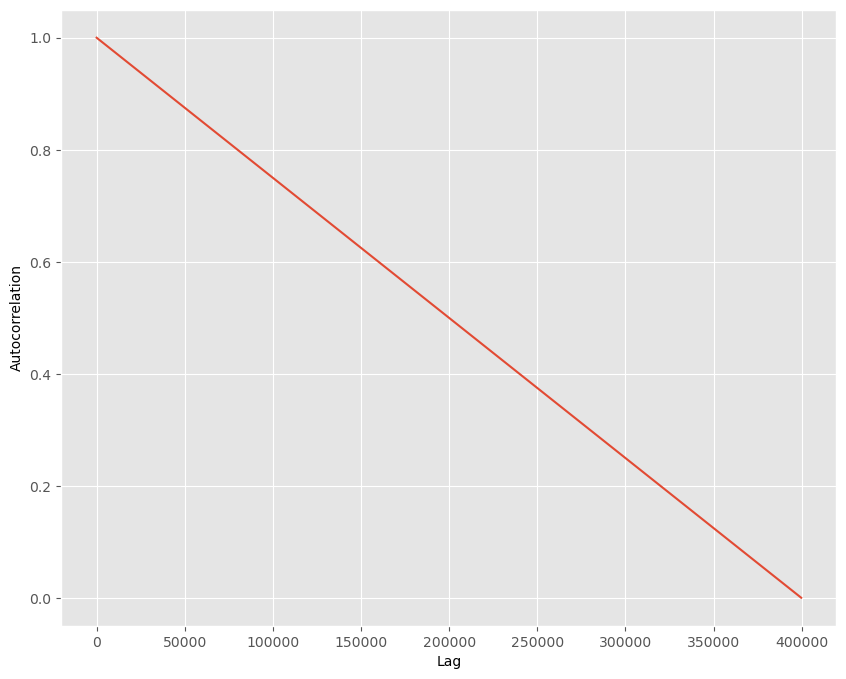

In [21]:
for file in data_files:
    data_autocorr(file, 'jiffies', (None, None), None, 'fft')

In [22]:
from statsmodels.graphics.tsaplots import plot_acf 

data_path = path + "\\csv\\" + data_files[0] + ".csv"
data = pd.read_csv(data_path)
x = np.array(data['jiffies'])

# plot_acf(x)

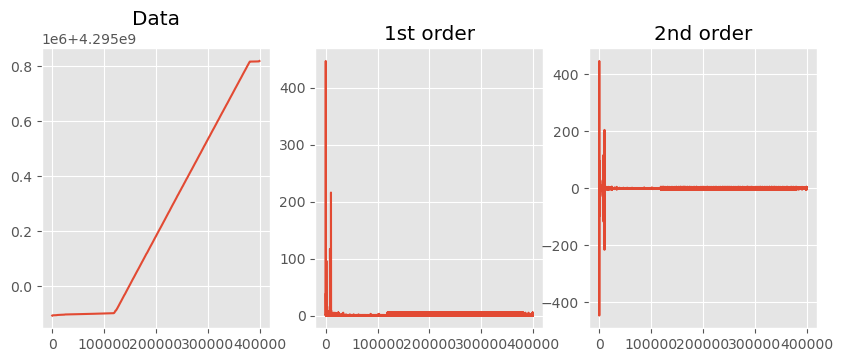

In [23]:
f = plt.figure()

ax1 = f.add_subplot(231)
ax1.set_title('Data')
ax1.plot(data.jiffies)

ax2 = f.add_subplot(232)
ax2.set_title('1st order')
ax2.plot(data.jiffies.diff())

ax3 = f.add_subplot(233)
ax3.set_title('2nd order')
ax3.plot(data.jiffies.diff().diff())

plt.show()

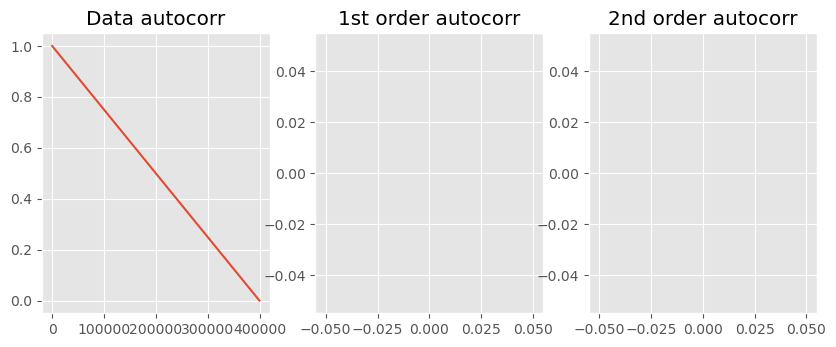

In [24]:
f = plt.figure()
ax1a = f.add_subplot(231)
ax1a.set_title('Data autocorr')
ax1a.plot(fft_autocorr(data.jiffies))

ax2a = f.add_subplot(232)
ax2a.set_title('1st order autocorr')
ax2a.plot(fft_autocorr(data.jiffies.diff()))

ax3a = f.add_subplot(233)
ax3a.set_title('2nd order autocorr')
ax3a.plot(fft_autocorr(data.jiffies.diff().diff()))

plt.show()

# III - 1st order differencing
## 1) Probability functions

In [25]:
def diff(df, columns):
    for col in columns:
        y = df[col].to_numpy()
        y =  y - np.roll(y.copy(), 1)
        y[0] = 0 # Should remove?
        df.loc[:, col] = y
#         return df.drop(0).reset_index(drop=True)

## 2) Density visualisation

moduntu_HP_desktop_trace_jiffies_23.10.15_1h


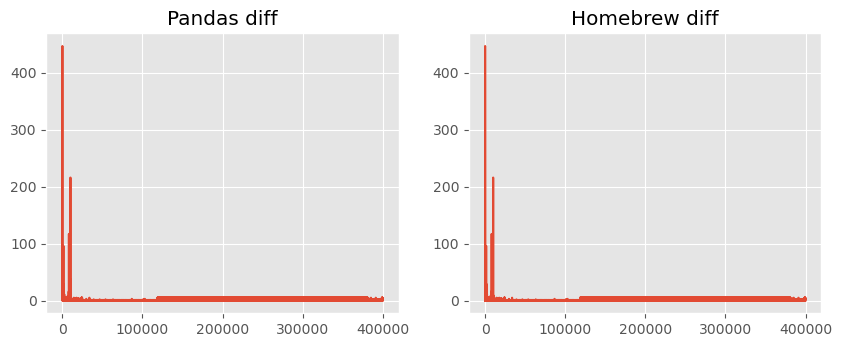

In [26]:
for file in data_files[:1]:
    print(file)
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    f = plt.figure()
    ax1 = f.add_subplot(221)
    ax1.set_title('Pandas diff')
    ax1.plot(data.jiffies.diff())
    
    diff(data, ['jiffies'])
    ax2 = f.add_subplot(222)
    ax2.set_title('Homebrew diff')
    ax2.plot(data.jiffies)

    plt.show()

In [27]:
value_counts = data['jiffies'].value_counts()
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['Unique Value', 'Count']
value_counts_df['Ratio'] = value_counts_df['Count'] / data.shape[0]
value_counts_df['Percentage'] = value_counts_df['Ratio'] * 100
value_counts_df

,Unique Value,Count,Ratio,Percentage
0,4,182131,0.455692,45.569205
1,0,167495,0.419073,41.907276
2,5,35376,0.088511,8.851081
3,1,11109,0.027795,2.779474
4,2,1927,0.004821,0.482136
5,3,1602,0.004008,0.400821
6,16,6,0.000015,0.001501
7,6,5,0.000013,0.001251
8,9,4,0.000010,0.001001
9,11,3,0.000008,0.000751


In [28]:
(45.569205+41.907276+8.851081+2.779474+0.482136+0.400821)

99.98999299999998

In [29]:
max(data['jiffies']), min(data['jiffies'])

(447, 0)

In [30]:
value_counts = data['irq'].value_counts()
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['Unique Value', 'Count']
value_counts_df['Ratio'] = value_counts_df['Count'] / data.shape[0]
value_counts_df['Percentage'] = value_counts_df['Ratio'] * 100
value_counts_df

,Unique Value,Count,Ratio,Percentage
0,90,225041,0.563053,56.305294
1,76,21039,0.052640,5.263961
2,77,19693,0.049272,4.927192
3,10,17856,0.044676,4.467574
4,70,15286,0.038246,3.824560
5,75,14041,0.035131,3.513060
6,69,13480,0.033727,3.372698
7,73,13339,0.033374,3.337420
8,72,11937,0.029866,2.986639
9,71,10617,0.026564,2.656375


In [31]:
def data_diff_hist(filename, column, selection = [], crop = (None, None), slicer = (None, None), log = False, bins = None):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    # Selection: select data according to other columns (origin, process...)
    for tup in selection: 
        data = data[data[tup[0]] == tup[1]] 

    # Cropping: remove crop[0] % of beginning or crop[0] of end of the data (if not idle)
    n = data.shape[0]
    if crop[0] != None and int(crop[0]*n) > 0: 
        data = data.tail(-int( n*crop[0] ))
    if crop[1] != None and int(crop[1]*n) > 0: 
        data = data.head(-int( n*crop[1] ))
        
    diff(data, ['jiffies'])
    
    fig, ax = plt.subplots()
    bins = max(int(data.shape[0]/128) if not bins else bins, 1)
    plt.hist(data[column], density=True,  log = log, bins = bins)
    print("Histogram of", filename, ":")
    print("\t selection:", tup_string(selection))
    print("\t crop values:", str(0 if not crop[0] else int(crop[0]*n))+",", str(0 if not crop[1] else int(crop[1]*n)))
    print("\t # of elements:", str(data.shape[0]))
    print("\t # of bins:", str(bins))
    print("\t log =", str(log))
    
    ax.set_xlabel(u'Jiffies value')
    ax.set_ylabel('Frequency')

    plt.show()

Histogram of moduntu_HP_desktop_trace_jiffies_23.10.15_1h :
	 selection: idle = True
	 crop values: 72845, 36422
	 # of elements: 254962
	 # of bins: 500
	 log = True


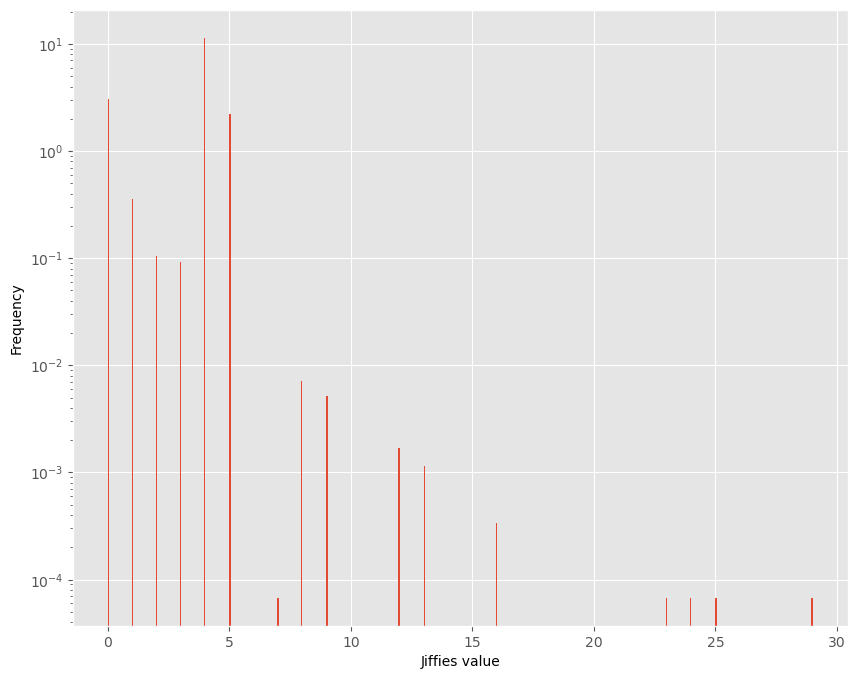

In [33]:
for file in data_files:
    data_diff_hist(file, 'jiffies', selection = [('idle', True)], crop = (0.2, 0.1), slicer = (None, None), 
              log = True, bins = 500)